# Control probing for untrained model

The following notebook contains probing control tests performed for randomly initialized untrained model.

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-untrained'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=11, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom, separator = meta['stoi'], meta['itos'], meta['stom'], meta['separator']
split = lambda s: list(s) if separator == '' else s.split(separator)
encode = lambda s: [stoi[c] for c in split(s)]
decode = lambda l: separator.join(itos[i] for i in l)
str_to_moves = lambda s: ''.join(stom[c] for c in split(s))
ids_to_moves = lambda l: ''.join(stom[itos[i]] for i in l)

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Probing

### Get output from hidden layers of the model

In [6]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [7]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = []
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        X.append(activations['block_5'][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = torch.stack(X)
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [8]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [9]:
train_X.shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [10]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [11]:
val_X.shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

### Train linear probes

In [12]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [13]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [14]:
def train_probe(X, Y, num_cls):
    probe = LinearBoardProbe(dim_x=X.shape[-1], dim_y=Y.shape[-1], num_cls=num_cls).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        probe.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    epochs = 1024
    batch_size = 1024

    train_loader = get_data_loader(X, Y, batch_size)

    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)

            loss = criterion(
                preds.view(-1, probe._num_cls),
                y.view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

    return probe, train_loader

Predict value of each cell

In [15]:
cell_probe, cell_train_loader = train_probe(train_X, train_Y_cell, num_cls=3)

Epoch   0: 1.0681
Epoch   1: 1.0042
Epoch   2: 0.9591
Epoch   3: 0.9278
Epoch   4: 0.9054
Epoch   5: 0.8880
Epoch   6: 0.8742
Epoch   7: 0.8624
Epoch   8: 0.8521
Epoch   9: 0.8428
Epoch  10: 0.8344
Epoch  11: 0.8266
Epoch  12: 0.8193
Epoch  13: 0.8125
Epoch  14: 0.8060
Epoch  15: 0.8000
Epoch  16: 0.7942
Epoch  17: 0.7888
Epoch  18: 0.7837
Epoch  19: 0.7787
Epoch  20: 0.7739
Epoch  21: 0.7693
Epoch  22: 0.7650
Epoch  23: 0.7608
Epoch  24: 0.7567
Epoch  25: 0.7529
Epoch  26: 0.7491
Epoch  27: 0.7454
Epoch  28: 0.7421
Epoch  29: 0.7387
Epoch  30: 0.7354
Epoch  31: 0.7323
Epoch  32: 0.7292
Epoch  33: 0.7263
Epoch  34: 0.7234
Epoch  35: 0.7206
Epoch  36: 0.7179
Epoch  37: 0.7153
Epoch  38: 0.7127
Epoch  39: 0.7103
Epoch  40: 0.7078
Epoch  41: 0.7055
Epoch  42: 0.7032
Epoch  43: 0.7010
Epoch  44: 0.6988
Epoch  45: 0.6966
Epoch  46: 0.6946
Epoch  47: 0.6926
Epoch  48: 0.6906
Epoch  49: 0.6887
Epoch  50: 0.6868
Epoch  51: 0.6850
Epoch  52: 0.6831
Epoch  53: 0.6815
Epoch  54: 0.6798
Epoch  55:

Predict number of pieces in each column

In [16]:
col_probe, col_train_loader = train_probe(train_X, train_Y_col, num_cls=7)

Epoch   0: 1.9169
Epoch   1: 1.8646
Epoch   2: 1.8269
Epoch   3: 1.7979
Epoch   4: 1.7743
Epoch   5: 1.7537
Epoch   6: 1.7352
Epoch   7: 1.7180
Epoch   8: 1.7021
Epoch   9: 1.6870
Epoch  10: 1.6727
Epoch  11: 1.6591
Epoch  12: 1.6463
Epoch  13: 1.6340
Epoch  14: 1.6223
Epoch  15: 1.6111
Epoch  16: 1.6004
Epoch  17: 1.5901
Epoch  18: 1.5801
Epoch  19: 1.5706
Epoch  20: 1.5615
Epoch  21: 1.5527
Epoch  22: 1.5441
Epoch  23: 1.5360
Epoch  24: 1.5279
Epoch  25: 1.5203
Epoch  26: 1.5127
Epoch  27: 1.5056
Epoch  28: 1.4985
Epoch  29: 1.4918
Epoch  30: 1.4851
Epoch  31: 1.4786
Epoch  32: 1.4724
Epoch  33: 1.4664
Epoch  34: 1.4605
Epoch  35: 1.4546
Epoch  36: 1.4490
Epoch  37: 1.4436
Epoch  38: 1.4381
Epoch  39: 1.4328
Epoch  40: 1.4277
Epoch  41: 1.4227
Epoch  42: 1.4178
Epoch  43: 1.4130
Epoch  44: 1.4082
Epoch  45: 1.4037
Epoch  46: 1.3991
Epoch  47: 1.3946
Epoch  48: 1.3904
Epoch  49: 1.3861
Epoch  50: 1.3820
Epoch  51: 1.3779
Epoch  52: 1.3738
Epoch  53: 1.3698
Epoch  54: 1.3660
Epoch  55:

Predict number of pieces in each row

In [17]:
row_probe, row_train_loader = train_probe(train_X, train_Y_row, num_cls=8)

Epoch   0: 2.0277
Epoch   1: 1.9479
Epoch   2: 1.8841
Epoch   3: 1.8321
Epoch   4: 1.7891
Epoch   5: 1.7526
Epoch   6: 1.7210
Epoch   7: 1.6926
Epoch   8: 1.6669
Epoch   9: 1.6431
Epoch  10: 1.6209
Epoch  11: 1.6000
Epoch  12: 1.5804
Epoch  13: 1.5618
Epoch  14: 1.5441
Epoch  15: 1.5273
Epoch  16: 1.5111
Epoch  17: 1.4958
Epoch  18: 1.4810
Epoch  19: 1.4669
Epoch  20: 1.4534
Epoch  21: 1.4403
Epoch  22: 1.4278
Epoch  23: 1.4157
Epoch  24: 1.4041
Epoch  25: 1.3929
Epoch  26: 1.3821
Epoch  27: 1.3717
Epoch  28: 1.3615
Epoch  29: 1.3518
Epoch  30: 1.3423
Epoch  31: 1.3332
Epoch  32: 1.3244
Epoch  33: 1.3158
Epoch  34: 1.3076
Epoch  35: 1.2995
Epoch  36: 1.2917
Epoch  37: 1.2842
Epoch  38: 1.2769
Epoch  39: 1.2698
Epoch  40: 1.2628
Epoch  41: 1.2561
Epoch  42: 1.2496
Epoch  43: 1.2432
Epoch  44: 1.2370
Epoch  45: 1.2311
Epoch  46: 1.2252
Epoch  47: 1.2195
Epoch  48: 1.2140
Epoch  49: 1.2086
Epoch  50: 1.2033
Epoch  51: 1.1982
Epoch  52: 1.1932
Epoch  53: 1.1883
Epoch  54: 1.1835
Epoch  55:

### Test linear probes

In [18]:
def eval_probe(probe, loader, dim):
    correct = torch.zeros(dim, device=DEVICE)
    total = torch.zeros(dim, device=DEVICE)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)
            pred_cls = preds.argmax(dim=-1)
            matches = (pred_cls == y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

    return correct / total

In [19]:
def plot_heatmap(acc, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False):
    board = acc.view(h, w).cpu()

    plt.figure()
    plt.imshow(board)
    plt.colorbar(label='Accuracy')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if disable_yticks:
        plt.yticks([])
    if disable_xticks:
        plt.xticks([])

    for i in range(h):
        for j in range(w):
            val = board[i, j].item()
            plt.text(
                j, i,
                f'{val:.2f}',
                ha='center',
                va='center'
            )

    plt.show()

Per cell

In [20]:
train_acc_cell = eval_probe(cell_probe, cell_train_loader, dim=train_Y_cell.shape[-1])
train_acc_cell

tensor([0.7794, 0.7896, 0.7820, 0.7461, 0.8194, 0.8615, 0.9074, 0.7476, 0.7546,
        0.7333, 0.6960, 0.7766, 0.8203, 0.8801, 0.7157, 0.7161, 0.6930, 0.6516,
        0.7299, 0.7632, 0.8370, 0.6890, 0.6706, 0.6706, 0.6432, 0.6989, 0.7301,
        0.8052, 0.6522, 0.6410, 0.6377, 0.5987, 0.6442, 0.6760, 0.7494, 0.6159,
        0.6128, 0.6311, 0.6337, 0.6170, 0.6263, 0.6600], device='cuda:0')

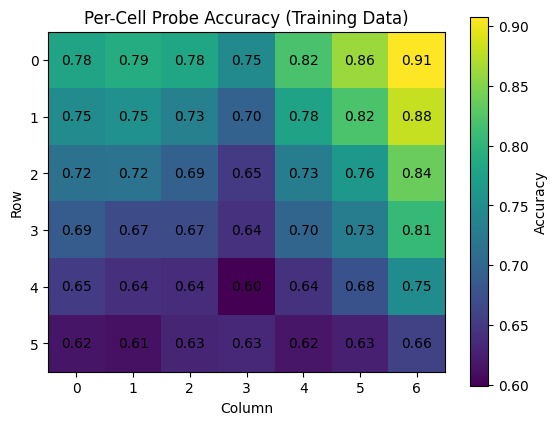

In [21]:
plot_heatmap(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [22]:
cell_val_loader = get_data_loader(val_X, val_Y_cell)
val_acc_cell = eval_probe(cell_probe, cell_val_loader, val_Y_cell.shape[-1])
val_acc_cell

tensor([0.7970, 0.7891, 0.7933, 0.7474, 0.8076, 0.8573, 0.9086, 0.7415, 0.7505,
        0.7336, 0.6845, 0.7648, 0.8118, 0.8895, 0.7035, 0.7130, 0.6718, 0.6416,
        0.7230, 0.7548, 0.8425, 0.6845, 0.6591, 0.6512, 0.6232, 0.6834, 0.7172,
        0.8044, 0.6427, 0.6438, 0.6300, 0.6099, 0.6480, 0.6781, 0.7341, 0.5914,
        0.6173, 0.6152, 0.6237, 0.6121, 0.6305, 0.6438], device='cuda:0')

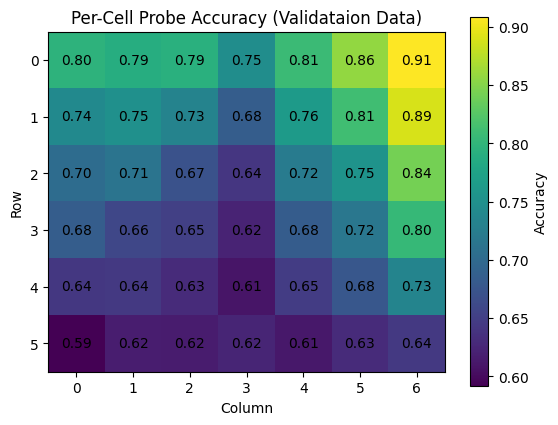

In [23]:
plot_heatmap(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [24]:
train_acc_col = eval_probe(col_probe, col_train_loader, dim=train_Y_col.shape[-1])
train_acc_col

tensor([0.6673, 0.6725, 0.6733, 0.6551, 0.6383, 0.6295, 0.6731],
       device='cuda:0')

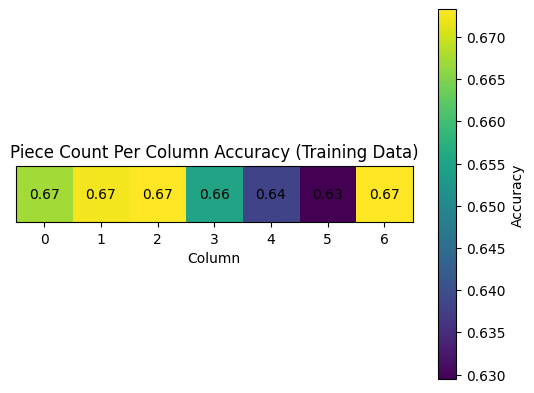

In [25]:
plot_heatmap(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [26]:
col_val_loader = get_data_loader(val_X, val_Y_col)
val_acc_col = eval_probe(col_probe, col_val_loader, val_Y_col.shape[-1])
val_acc_col

tensor([0.6596, 0.6422, 0.6617, 0.6490, 0.6517, 0.6274, 0.6543],
       device='cuda:0')

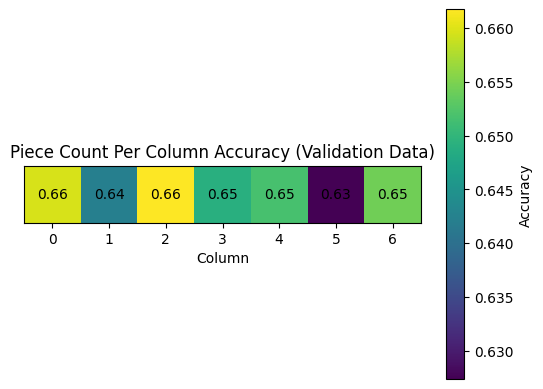

In [27]:
plot_heatmap(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [28]:
train_acc_row = eval_probe(row_probe, row_train_loader, dim=train_Y_row.shape[-1])
train_acc_row

tensor([0.6627, 0.6186, 0.6358, 0.6358, 0.6110, 0.6149], device='cuda:0')

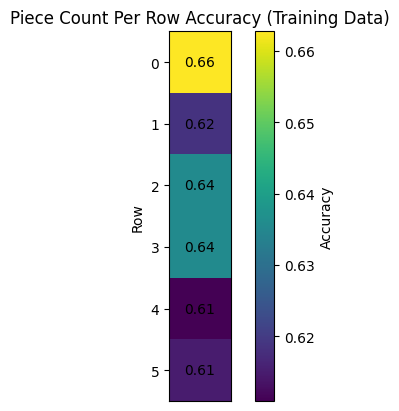

In [29]:
plot_heatmap(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [30]:
row_val_loader = get_data_loader(val_X, val_Y_row)
val_acc_row = eval_probe(row_probe, row_val_loader, val_Y_row.shape[-1])
val_acc_row

tensor([0.6633, 0.6184, 0.6443, 0.6364, 0.6041, 0.6126], device='cuda:0')

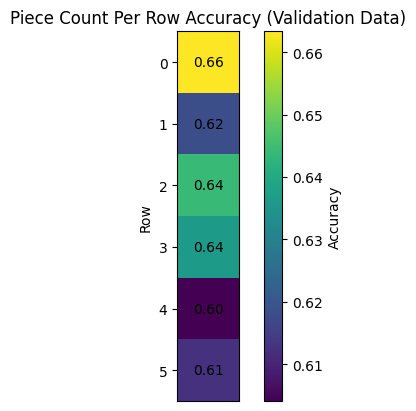

In [31]:
plot_heatmap(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)